## Diffusion lengthscale

Toy model of 1-D diffusion of a linear concentration profile through two layers with different diffusivities. 

We discretize the 1-D diffusion equation 

$$\frac{\partial C}{\partial t} =  \frac{\partial}{\partial z}\Big(\frac{\kappa\partial C}{\partial z}\Big)$$

using using forward differences for time and the spatial stencil

 o----x----o----x----o    

i-1---ki---i---ki+1--i+1   

Ci-1-------Ci--------Ci+1   


as

$$\frac{C_i^{n+1}-C_i^{n}}{\Delta t}= \frac{\kappa_i(C_{i}^n-C_{i-1}^n)-\kappa_{i+1}(C_{i+1}^n-C_i^n)}{\Delta z^2}$$

using forward differences for time. Note that when $\kappa_i = \kappa_{i+1}$, we recover the usual central differences scheme for the second derivative:

$$\frac{C_i^{n+1}-C_i^{n}}{\Delta t}= \frac{\kappa(C_{i+1}^n-2C_{i}^n+C_{i-1}^n)}{\Delta z^2}$$

So, we calculate the concentration at time step n+1 as

$$C_i^{n+1}=\frac{\Delta t}{\Delta z^2}(\kappa_i(C_{i}^n-C_{i-1}^n)-\kappa_{i+1}(C_{i+1}^n-C_i^n)) + C_i^{n}$$.


In [52]:
import cmocean as cmo
import numpy as np               
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
# Plots appearance
sns.set_context('notebook')
sns.set_style('whitegrid')

In [44]:
def timestepping(IC, kappa, dt, dz, nt):
    '''Iterate for nt timesteps the solution to the diffusion equation
    INPUT
    IC: vector with the initial condition (1D numpy array)
    kappa: 1D numpy array, same size as u
    dt: timestep size (scalar)
    dz: depth of cells (scalar)
    nt: number of timesteps
    
    OUTPUT
    u: 1d numpy array with concentrations after nt timesteps.
    '''
    un = np.ones(nz) #our placeholder array, un, to advance the solution in time
    u = np.ones(nz) #our placeholder array, un, to advance the solution in time
    u = IC.copy()
    
    for n in range(nt):  #iterate through time
        un = u.copy() ##copy the existing values of u into un
        for i in range(1, nz - 1):
            u[i] = un[i] + (kappa[i] * dt / dz**2 * (un[i+1] - 2 * un[i] + un[i-1]))
    return u

def timesteppingKv(IC, kappa, dt, dz, nt):
    '''Iterate for nt timesteps the solution to the diffusion equation with variable Kv
    INPUT
    IC: vector with the initial condition (1D numpy array)
    kappa: 1D numpy array, same size as u
    dt: timestep size (scalar)
    dz: depth of cells (scalar)
    nt: number of timesteps
    
    OUTPUT
    u: 1d numpy array with concentrations after nt timesteps.
    '''
    un = np.ones(nz) 
    u = np.ones(nz) 
    u = IC.copy()
    
    for n in range(nt):  #iterate through time
        un = u.copy() ##copy the existing values of u into un
        for i in range(1, nz - 1):
            u[i] = un[i] + dt * (kappa[i]*(un[i-1]-un[i])/dz**2 - kappa[i+1]*(un[i]-un[i+1])/dz**2)
    return u

def smoothHS(nx, xi, epsilon, dx, k1, k2):
    '''Build smooth Heaviside function, of width 2*epsilon centred at index xi
    Check:
    xi < nx ''' 
    
    hs = np.zeros(nx)
    
    hs[:xi-epsilon+1] = k1
    
    for ii in range(2*epsilon):
        hs[xi+ii-epsilon] = k1+(0.5 + (ii-epsilon)/(2*epsilon) + 
                             (np.sin(np.pi*(ii-epsilon)/epsilon))/(2*np.pi))*k2
    
    hs[xi+epsilon-1:] = k2+k1
    
    return hs
     
    
def plotICs(IniC,kappa,L,nz):
    '''Plots initial conditions and diffusivity profile, creates figure inside and returns fig and ax handles'''
    fig,(ax1,ax2) = plt.subplots(1,2,sharey = True,figsize=(8,3))

    ax1.plot(IniC, np.linspace(0, L, nz))
    ax1.set_xlabel('Concentration ($\mu M$)')
    ax1.set_ylabel('Depth (m)')
    ax1.set_title('Initial concentration')

    ax2.plot(kappa,np.linspace(0, L, nz))
    ax2.set_xlabel('$\kappa$ (m$^2$s$^{-1}$)')
    ax2.set_title('Diffusivity profile')
    ax2.invert_yaxis()
    
    return(fig,ax1,ax2)

def plotC(ax, C, L, nz):
    '''Plots concentration over an existing ax and returns ax handle and line handle'''
    ax.axhline(L/2, color='0.8', linestyle='--')
    line, = ax.plot(C, np.linspace(0, L, nz));
    ax.set_xlabel('Concentration ($\mu M$)')
    ax.set_ylabel('Depth (m)')
    return (line)

In [40]:
# INITIALIZATION 

# Space
nz = 100           # number of points in z
L = 100            # total depth (m)
dz = L / (nz - 1)  # vertical spacing (m)

# Time
dt = 60  # time step (s)
to_day = dt/(3600*24)

# Diffusivity
kappa_bg = 1E-5              # background diffusivity
kappa_can = 1E-3             # canyon diffusivity
kappa = np.ones(nz)*kappa_bg # Diffuisivity profile
kappa[int(nz/2):] = kappa_can

#epsilon = 10
#kappa = smoothHS(nz, 50, epsilon, dz, kappa_bg, kappa_can)

# Talk to me
print('The time step is %1.1f seconds' %dt)
print('The vertical resolution is %1.3f meters' %dz)

The time step is 60.0 seconds
The vertical resolution is 1.010 meters


## Hat profile

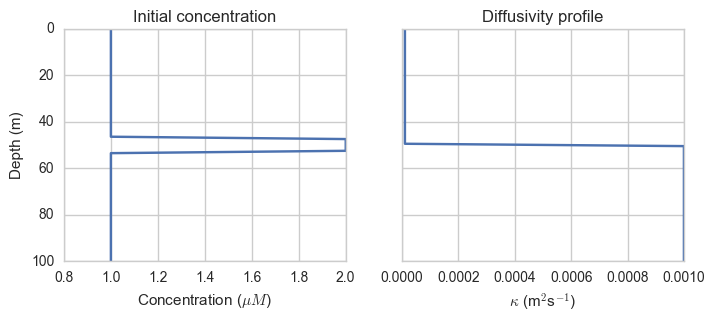

In [5]:
# Initial conditon
IC = np.ones(nz)     
IC[int(nz/2)-3:int(nz/2)+3] = 2  # It's a hat 

fig, ax1, ax2 = plotICs(IC,kappa,L,nz)

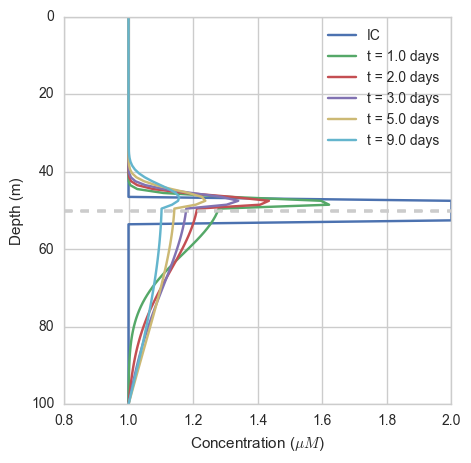

In [6]:
# PLOT RESULTING CONCENTRATION

fig, ax = plt.subplots(1,1, figsize=(5,5))
l1 = plotC(ax, IC, L, nz)
lines = [l1]

times = [1440,2880,4320,7200, 12960]

for time in times:
    conc = timesteppingKv(IC, kappa, dt, dz, time)
    l2 = plotC(ax, conc, L, nz)
    lines.append(l2)

ax.invert_yaxis()
ax.legend((lines), ('IC', '%1.1f days' %(times[0]*to_day),
                    '%1.1f days' %(times[1]*to_day),
                    '%1.1f days' %(times[2]*to_day),
                    '%1.1f days'%(times[3]*to_day),
                    '%1.1f days'%(times[4]*to_day))) 

Now, let's compare to the diffusion discretization when we don't take into account the derivative of $\kappa$:

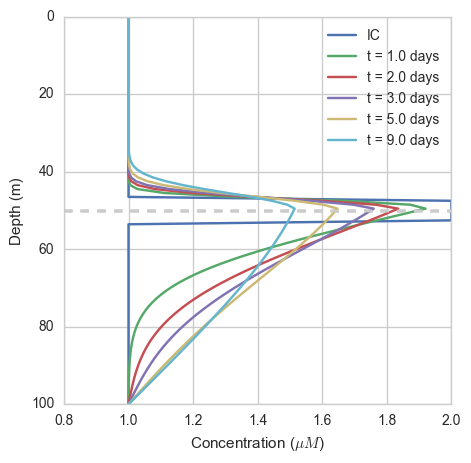

In [7]:
# PLOT RESULTING CONCENTRATION

fig, ax = plt.subplots(1,1, figsize=(5,5))
l1 = plotC(ax, IC, L, nz)
lines = [l1]

times = [1440,2880,4320,7200, 12960]

for time in times:
    conc = timestepping(IC, kappa, dt, dz, time)
    l2 = plotC(ax, conc, L, nz)
    lines.append(l2)

ax.invert_yaxis()
ax.legend((lines), ('IC', '%1.1f days' %(times[0]*to_day),
                    '%1.1f days' %(times[1]*to_day),
                    '%1.1f days' %(times[2]*to_day),
                    '%1.1f days'%(times[3]*to_day),
                    '%1.1f days'%(times[4]*to_day))) 

## Parabolic profile

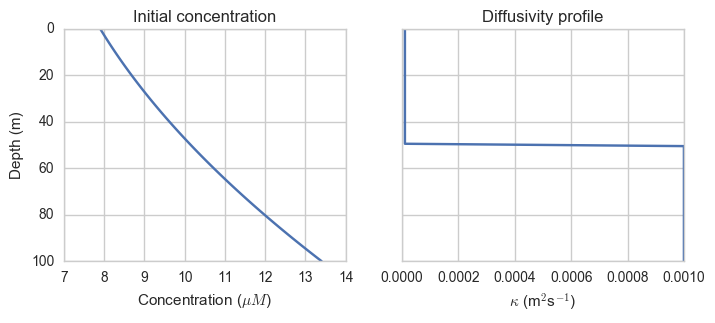

In [8]:
# Initial conditon
IC = np.ones(nz)
for ii in range(nz):
    IC[ii]=0.0002*(ii*dz)**2+0.035*ii*dz+7.9

fig, ax1, ax2 = plotICs(IC,kappa,L,nz)

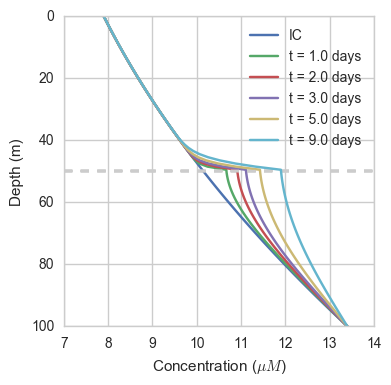

In [9]:
# PLOT RESULTING CONCENTRATION

fig, ax = plt.subplots(1,1, figsize=(4,4))
l1 = plotC(ax, IC, L, nz)
lines = [l1]

times = [1440,2880,4320,7200, 12960]

for time in times:
    conc = timesteppingKv(IC, kappa, dt, dz, time)
    l2 = plotC(ax, conc, L, nz)
    lines.append(l2)

ax.invert_yaxis()
ax.legend((lines), ('IC', '%1.1f days' %(times[0]*to_day),'%1.1f days' %(times[1]*to_day),
                     '%1.1f days' %(times[2]*to_day),'%1.1f days'%(times[3]*to_day),
                    '%1.1f days'%(times[4]*to_day))) 

## Linear profile

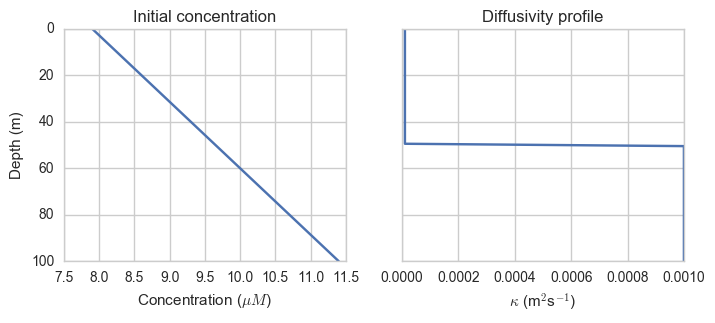

In [10]:
# Initial conditon
IC = np.ones(nz)
for ii in range(nz):
    IC[ii]=0.035*ii*dz+7.9
    
fig, ax1, ax2 = plotICs(IC,kappa,L,nz)

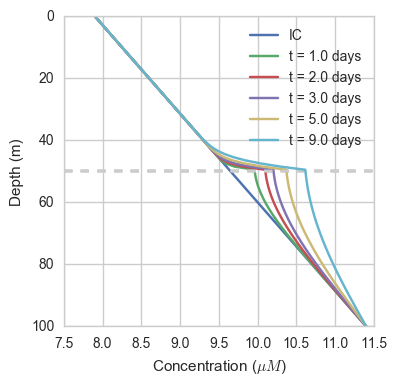

In [11]:
# PLOT RESULTING CONCENTRATION

fig, ax = plt.subplots(1,1, figsize=(4,4))
l1 = plotC(ax, IC, L, nz)
lines = [l1]

times = [1440,2880,4320,7200, 12960]

for time in times:
    conc = timesteppingKv(IC, kappa, dt, dz, time)
    l2 = plotC(ax, conc, L, nz)
    lines.append(l2)

ax.invert_yaxis()
ax.legend((lines), ('IC', '%1.1f days' %(times[0]*to_day),'%1.1f days' %(times[1]*to_day),
                     '%1.1f days' %(times[2]*to_day),'%1.1f days'%(times[3]*to_day),
                    '%1.1f days'%(times[4]*to_day))) 

## Smoothed $\kappa$ profile

What happens if we smooth out the diffusivity profile from a step (Heaviside function) to a smoothed Heaviside function? (The concentration will look smoother but how does it change the tracer transport?)

Smoothed Heaviside function:

$HS(z) = \begin{cases}
\kappa_{bg} &\mbox{if } z<\frac{L}{2}-\epsilon \\
\kappa_{bg}+ \kappa_{can}(0.5 + \frac{z-\epsilon}{2\epsilon} + \frac{1}{2\pi}\sin{\frac{\pi(z-\epsilon)}{\epsilon}}) & \mbox{if } \frac{L}{2}-\epsilon < z < \frac{L}{2}+\epsilon \\
\kappa_{can} & \mbox{if }  \frac{L}{2}+\epsilon < z
 \end{cases} $

We will compare several values of $\epsilon$.

In [21]:
# Smoothed Heaviside function for diffusivity
e01 = 1
kappa_e01 = smoothHS(nz, int(nz/2), e01, dz, kappa_bg, kappa_can)

e05 = 5
kappa_e05 = smoothHS(nz, int(nz/2), e05, dz, kappa_bg, kappa_can)

e10 = 10
kappa_e10 = smoothHS(nz, int(nz/2), e10, dz, kappa_bg, kappa_can)

e25 = 25
kappa_e25 = smoothHS(nz, int(nz/2), e25, dz, kappa_bg, kappa_can)

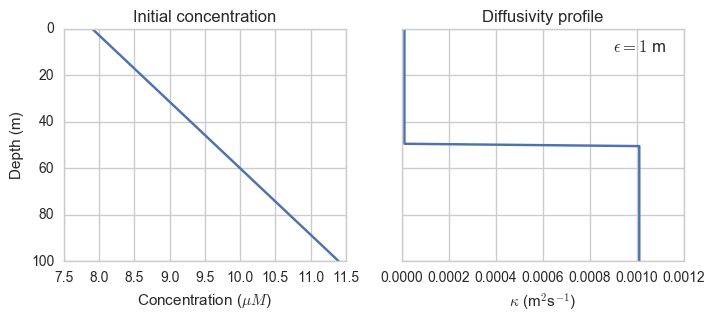

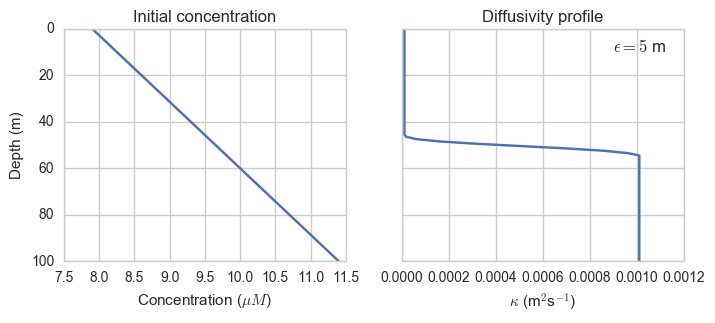

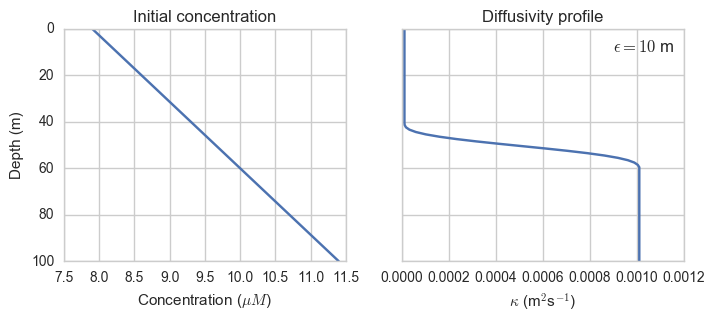

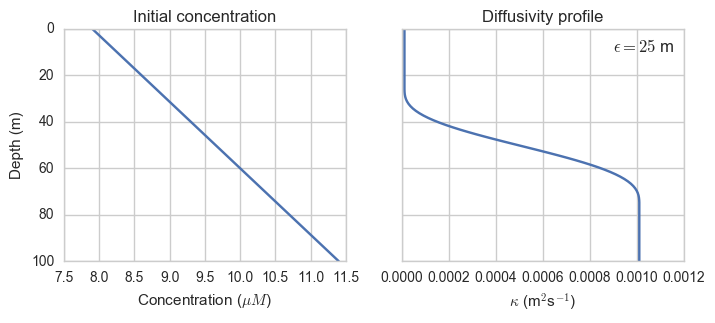

In [28]:
# Initial conditon
IC = np.ones(nz)
for ii in range(nz):
    IC[ii]=0.035*ii*dz+7.9

fig, ax1, ax2 = plotICs(IC,kappa_e01,L,nz)
ax2.text(0.0009,10,'$\epsilon=1$ m')
fig, ax1, ax2 = plotICs(IC,kappa_e05,L,nz)
ax2.text(0.0009,10,'$\epsilon=5$ m')
fig, ax1, ax2 = plotICs(IC,kappa_e10,L,nz)
ax2.text(0.0009,10,'$\epsilon=10$ m')
fig, ax1, ax2 = plotICs(IC,kappa_e25,L,nz)
ax2.text(0.0009,10,'$\epsilon=25$ m')

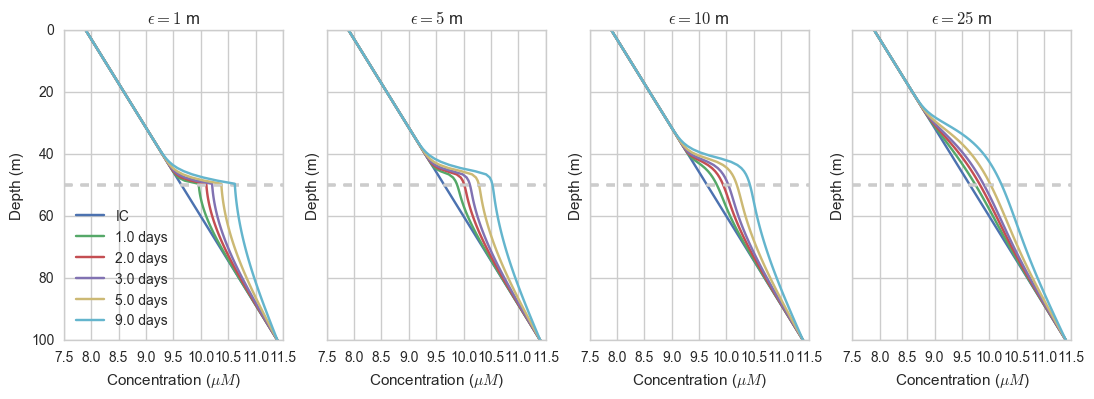

In [38]:
# PLOT RESULTING CONCENTRATION

fig, ax = plt.subplots(1,4, figsize=(13,4), sharey = True)

for axii in ax: 
    l1 = plotC(axii, IC, L, nz)
lines = [l1]

times = [1440,2880,4320,7200, 12960]

for time in times:
    conc01 = timesteppingKv(IC, kappa_e01, dt, dz, time)
    conc05 = timesteppingKv(IC, kappa_e05, dt, dz, time)
    conc10 = timesteppingKv(IC, kappa_e10, dt, dz, time)
    conc25 = timesteppingKv(IC, kappa_e25, dt, dz, time)
    l2 = plotC(ax[0], conc01, L, nz)
    l3 = plotC(ax[1], conc05, L, nz)
    l4 = plotC(ax[2], conc10, L, nz)
    l5 = plotC(ax[3], conc25, L, nz)
    lines.append(l2)

ax[0].invert_yaxis()
ax[0].legend((lines), ('IC', '%1.1f days' %(times[0]*to_day),'%1.1f days' %(times[1]*to_day),
                     '%1.1f days' %(times[2]*to_day),'%1.1f days'%(times[3]*to_day),
                    '%1.1f days'%(times[4]*to_day)), loc=0) 

ax[0].set_title('$\epsilon = 1$ m')
ax[1].set_title('$\epsilon = 5$ m')
ax[2].set_title('$\epsilon = 10$ m')
ax[3].set_title('$\epsilon = 25$ m')



## Concentration contours

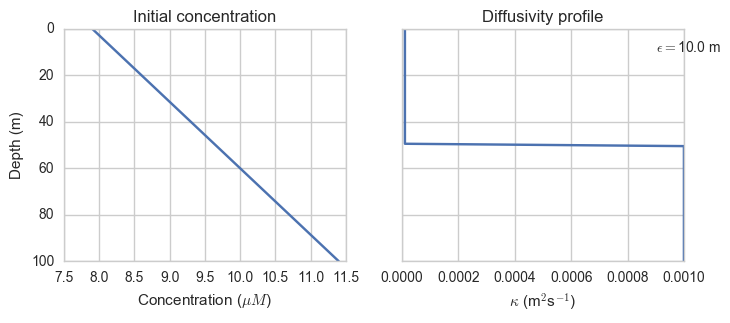

In [124]:
sns.set_style('whitegrid')

# Set diffusivity profile
kappa = np.ones(nz)*kappa_bg # Diffuisivity profile
kappa[int(nz/2):] = kappa_can

# Set initial conditon
IC = np.ones(nz)
for ii in range(nz):
    IC[ii]=0.035*ii*dz+7.9

# Plot initial condition
fig, ax1, ax2 = plotICs(IC,kappa,L,nz)

# Select times to output
times = [tt for tt in range(0,12960,288)]
nt = len(times)

# Timestepping
conc_2D = np.zeros((nz,nt)) 

for time,tt in zip(times,range(nt)):
    conc_2D[:,tt] = timesteppingKv(IC, kappa, dt, dz, time)
    IC = conc_2D[:,tt]

(100, 45)


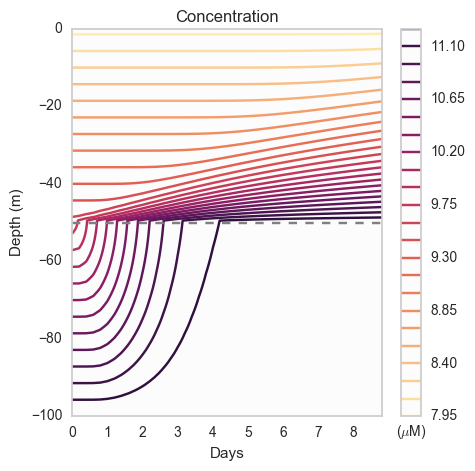

In [128]:
sns.set_style('white',{"axes.edgecolor": ".8", "axes.facecolor": "0.99"})

# Plot density contours
fig, ax = plt.subplots(1,1, figsize=(5,5), sharey = True)
ax.axhline(-int(nz/2), linestyle='--', color='0.5')

CS = ax.contour(np.array(times)*to_day,np.linspace(0, -L, nz),conc_2D, 25, cmap=cmo.cm.matter)
CB = plt.colorbar(CS, ax=ax)
ax.text(9.2,-105,'($\mu$M)')
ax.set_title('Concentration')
ax.set_xlabel('Days')
ax.set_ylabel('Depth (m)')

print(np.shape(conc_2D))

### Larger $\epsilon$ (smoother Kv profile)

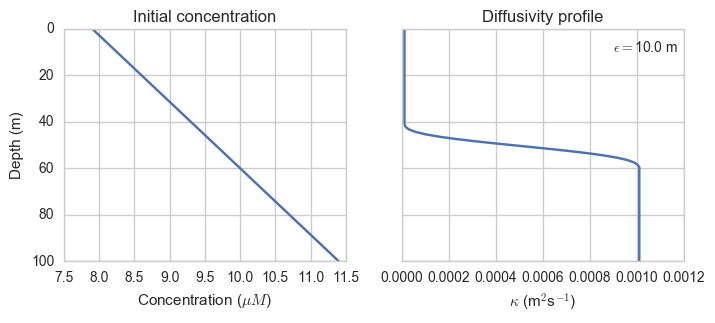

In [131]:
sns.set_style('whitegrid')

# Set diffusivity profile
epsilon = 10
kappa = smoothHS(nz, int(nz/2), epsilon, dz, kappa_bg, kappa_can)

# Set initial conditon
IC = np.ones(nz)
for ii in range(nz):
    IC[ii]=0.035*ii*dz+7.9

# Plot initial condition
fig, ax1, ax2 = plotICs(IC,kappa,L,nz)
ax2.text(0.0009,10,'$\epsilon=$%1.1f m' %epsilon)

# Select times to output
times = [tt for tt in range(0,12960,288)]
nt = len(times)

# Timestepping
conc_2D_e10 = np.zeros((nz,nt)) 

for time,tt in zip(times,range(nt)):
    conc_2D_e10[:,tt] = timesteppingKv(IC, kappa, dt, dz, time)
    IC = conc_2D_e10[:,tt]

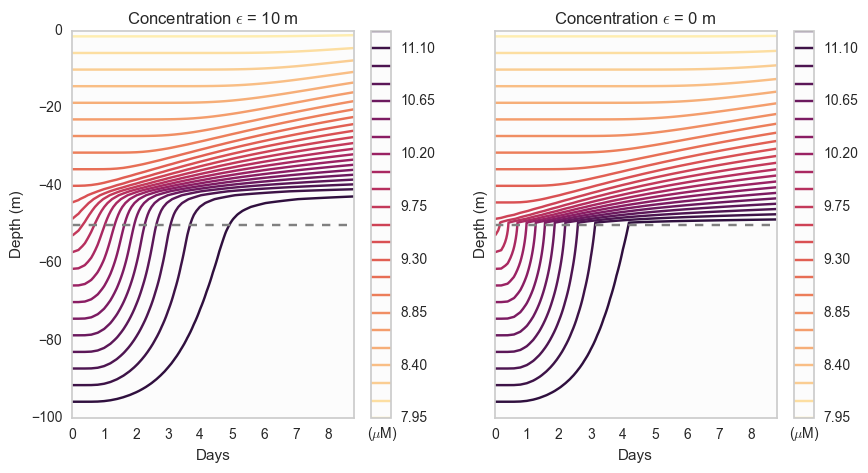

In [132]:
sns.set_style('white',{"axes.edgecolor": ".8", "axes.facecolor": "0.99"})

# Plot density contours
fig, ax = plt.subplots(1,2, figsize=(10,5), sharey = True)
ax[0].axhline(-50, linestyle='--', color='0.5')
ax[1].axhline(-int(nz/2), linestyle='--', color='0.5')

CS = ax[0].contour(np.array(times)*to_day,np.linspace(0, -L, nz),conc_2D_e10,25, cmap=cmo.cm.matter)
CB = plt.colorbar(CS, ax=ax[0])
ax[0].text(9.2,-105,'($\mu$M)')
ax[0].set_title('Concentration $\epsilon$ = 10 m')
ax[0].set_xlabel('Days')
ax[0].set_ylabel('Depth (m)')

CS = ax[1].contour(np.array(times)*to_day,np.linspace(0, -L, nz),conc_2D,25, cmap=cmo.cm.matter)
CB = plt.colorbar(CS, ax=ax[1])
ax[1].text(9.2,-105,'($\mu$M)')
ax[1].set_title('Concentration $\epsilon$ = 0 m')
ax[1].set_xlabel('Days')
ax[1].set_ylabel('Depth (m)')

## Smaller $\kappa_{can}$

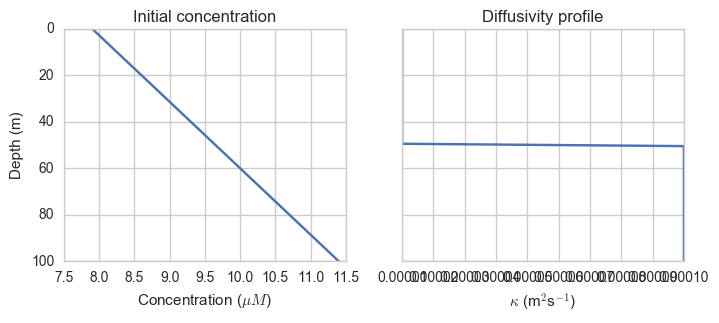

In [133]:
sns.set_style('whitegrid')

# Set diffusivity profile
kappa_sm = np.ones(nz)*kappa_bg # Diffuisivity profile
kappa_sm[int(nz/2):] = 1E-4

# Set initial conditon
IC = np.ones(nz)
for ii in range(nz):
    IC[ii]=0.035*ii*dz+7.9

# Plot initial condition
fig, ax1, ax2 = plotICs(IC,kappa_sm,L,nz)

# Select times to output
times = [tt for tt in range(0,12960,288)]
nt = len(times)

# Timestepping
conc_2D_sm = np.zeros((nz,nt)) 

for time,tt in zip(times,range(nt)):
    conc_2D_sm[:,tt] = timesteppingKv(IC, kappa_sm, dt, dz, time)
    IC = conc_2D_sm[:,tt]

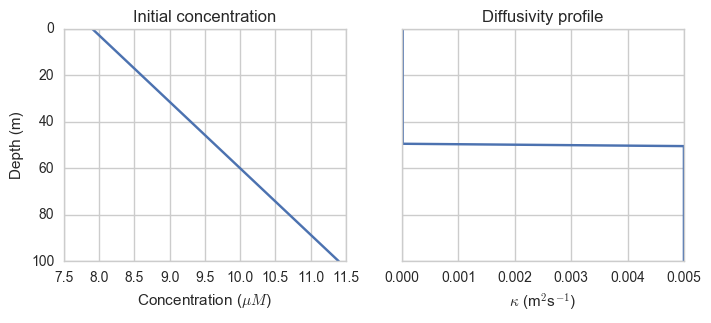

In [137]:
sns.set_style('whitegrid')

# Set diffusivity profile
kappa_bg = np.ones(nz)*kappa_bg # Diffuisivity profile
kappa_bg[int(nz/2):] = 5E-3

# Set initial conditon
IC = np.ones(nz)
for ii in range(nz):
    IC[ii]=0.035*ii*dz+7.9

# Plot initial condition
fig, ax1, ax2 = plotICs(IC,kappa_bg,L,nz)

# Select times to output
times = [tt for tt in range(0,12960,288)]
nt = len(times)

# Timestepping
conc_2D_bg = np.zeros((nz,nt)) 

for time,tt in zip(times,range(nt)):
    conc_2D_bg[:,tt] = timesteppingKv(IC, kappa_bg, dt, dz, time)
    IC = conc_2D_bg[:,tt]

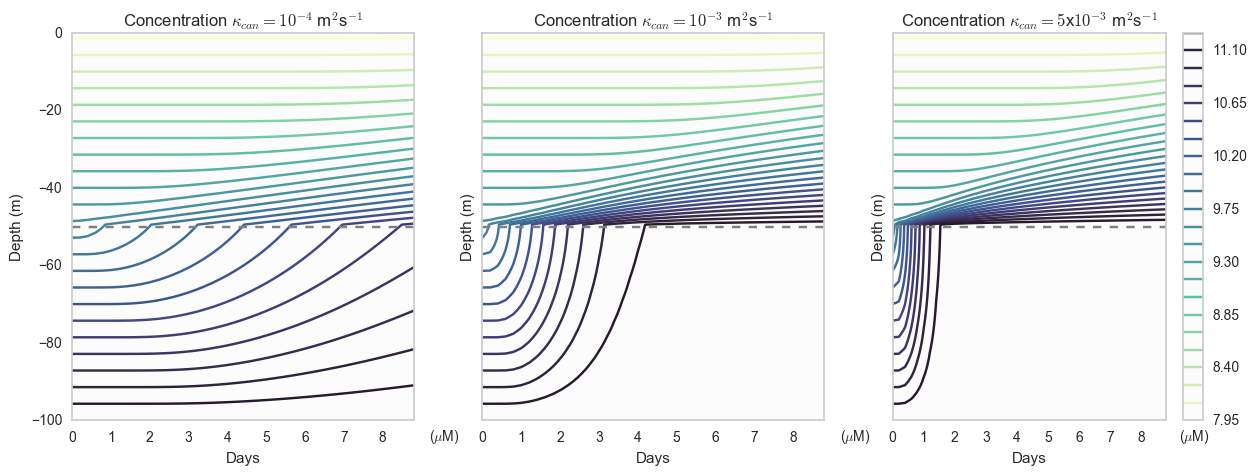

In [139]:
sns.set_style('white',{"axes.edgecolor": ".8", "axes.facecolor": "0.99"})

# Plot density contours
fig, ax = plt.subplots(1,3, figsize=(15,5), sharey = True)
ax[0].axhline(-int(nz/2), linestyle='--', color='0.5')
ax[1].axhline(-int(nz/2), linestyle='--', color='0.5')
ax[2].axhline(-int(nz/2), linestyle='--', color='0.5')

CS = ax[0].contour(np.array(times)*to_day,np.linspace(0, -L, nz),conc_2D_sm,25, cmap=cmo.cm.deep)
ax[0].text(9.2,-105,'($\mu$M)')
ax[0].set_title('Concentration $\kappa_{can}=10^{-4}$ m$^2$s$^{-1}$')
ax[0].set_xlabel('Days')
ax[0].set_ylabel('Depth (m)')

CS = ax[1].contour(np.array(times)*to_day,np.linspace(0, -L, nz),conc_2D,25, cmap=cmo.cm.deep)
ax[1].text(9.2,-105,'($\mu$M)')
ax[1].set_title('Concentration $\kappa_{can}=10^{-3}$ m$^2$s$^{-1}$')
ax[1].set_xlabel('Days')
ax[1].set_ylabel('Depth (m)')

CS = ax[2].contour(np.array(times)*to_day,np.linspace(0, -L, nz),conc_2D_bg,25, cmap=cmo.cm.deep)
CB = plt.colorbar(CS, ax=ax[2])
ax[2].text(9.2,-105,'($\mu$M)')
ax[2].set_title('Concentration $\kappa_{can}=5$x$10^{-3}$ m$^2$s$^{-1}$')
ax[2].set_xlabel('Days')
ax[2].set_ylabel('Depth (m)')

 Kappa_can = 10^-2 exploded.